In [ ]:
pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Customers_big.csv"

In [ ]:
data = spark.read.csv(data_path, header=True, inferSchema=True)
# data.printSchema()
#data.show(5)

In [ ]:
from pyspark.sql.functions import when, count, isnull
cols = data.columns
data.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()

+----------+------+---+-----------------+----------------------+----------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+----------+---------------+-----------+
|         0|     0|  0|                0|                     0|        35|              0|          0|
+----------+------+---+-----------------+----------------------+----------+---------------+-----------+



In [ ]:

from pyspark.sql.functions import isnan

# check schema to find all numeric cols
data.printSchema()

# list all numeric cols
num_cols = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']

# select a count of all the numeric columns where they are NaN and show
data.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income ($): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Work Experience: integer (nullable = true)
 |-- Family Size: integer (nullable = true)

+---+-----------------+----------------------+---------------+-----------+
|Age|Annual Income ($)|Spending Score (1-100)|Work Experience|Family Size|
+---+-----------------+----------------------+---------------+-----------+
|  0|                0|                     0|              0|          0|
+---+-----------------+----------------------+---------------+-----------+



In [ ]:
data = data.na.drop()

 Turn the string-typed 'Gender' Column into a number (0 for female, 1 for male) and add a new column to the dataframe containing numeric gender values

In [ ]:
indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
data = indexer.fit(data).transform(data)
indexer = StringIndexer(inputCol="Profession", outputCol="ProfessionIndex")
data = indexer.fit(data).transform(data)
#data.show(5)

In [ ]:
data.select('Profession','ProfessionIndex').distinct().collect()

[Row(Profession='Executive', ProfessionIndex=5.0),
 Row(Profession='Healthcare', ProfessionIndex=1.0),
 Row(Profession='Homemaker', ProfessionIndex=8.0),
 Row(Profession='Lawyer', ProfessionIndex=6.0),
 Row(Profession='Doctor', ProfessionIndex=4.0),
 Row(Profession='Engineer', ProfessionIndex=3.0),
 Row(Profession='Marketing', ProfessionIndex=7.0),
 Row(Profession='Entertainment', ProfessionIndex=2.0),
 Row(Profession='Artist', ProfessionIndex=0.0)]

In [ ]:
# Heatmap of Correlations
from pyspark.ml.stat import Correlation
from pyspark.ml.stat import Correlation
import pandas as pd

# Selecting only numeric columns for correlation calculation
numeric_columns = [col_name for col_name, data_type in data.dtypes if data_type in ['int', 'double']]
numeric_columns.remove('CustomerID')
numeric_df = data.select(numeric_columns)

# Assembling the columns into a single vector
vector_assembler = VectorAssembler(inputCols=numeric_df.columns, outputCol="features")
assembled_df = vector_assembler.transform(numeric_df)

# Calculating the correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()

# Getting the correlation matrix as a DenseMatrix object
correlation_matrix_values = correlation_matrix[0].toArray()

# Converting the correlation matrix to a Pandas DataFrame
correlation_matrix_pd = pd.DataFrame(correlation_matrix_values, columns=numeric_columns, index=numeric_columns)

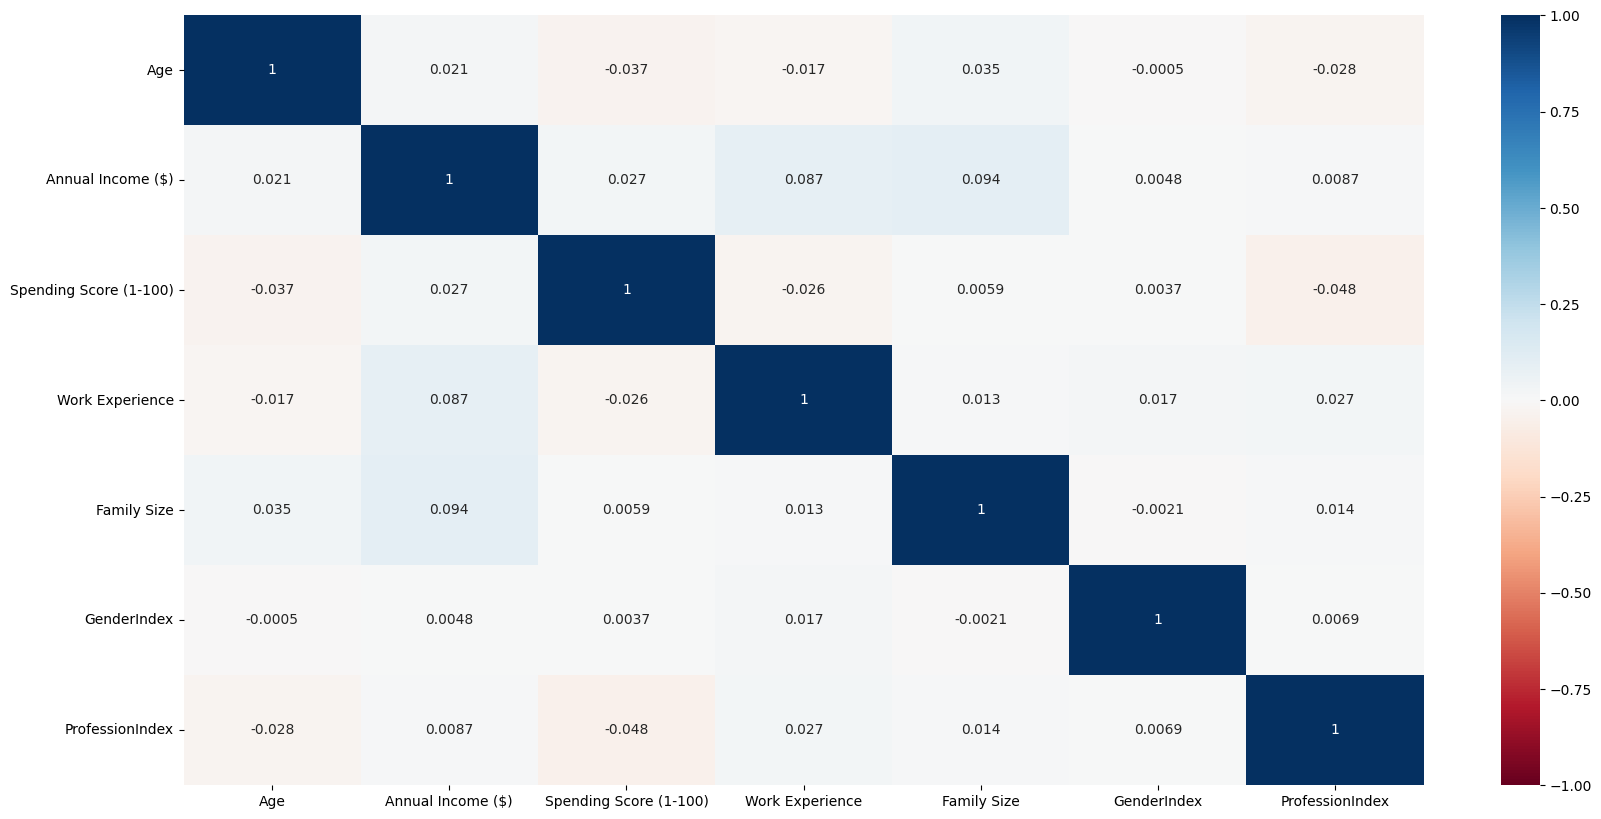

In [ ]:
# Visualizing the Correlation Matrix using Seaborn and Matplotlib
import seaborn as sns

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(correlation_matrix_pd,
                      annot=True,  # Show the numerical values of correlations
                      cmap="RdBu",
                      vmin=-1,
                      vmax=1)
plt.show()

Select the features you want to use, collect them into a single column and add this column to the dataframe

In [ ]:
input_features = ["Annual Income ($)", "Work Experience","Family Size"]
#input_features = ["Age","Spending Score (1-100)"]
#input_features = ["GenderIndex","Spending Score (1-100)"]
assembler = VectorAssembler(inputCols=input_features,outputCol="features")
data = assembler.transform(data)
data.show(5)

+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+-----------+---------------+-----------------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|GenderIndex|ProfessionIndex|         features|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+-----------+---------------+-----------------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|        1.0|            1.0|[15000.0,1.0,4.0]|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|        1.0|            3.0|[35000.0,3.0,3.0]|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|        0.0|            3.0|[86000.0,1.0,1.0]|
|         4|Female| 23|            59000|                    77|       Lawyer|    

In [ ]:
from pyspark.ml.feature import MinMaxScaler
minmscaler = MinMaxScaler(inputCol="features", max=1, min=0, outputCol="featuresNorm")
data = minmscaler.fit(data).transform(data)
data.show()


+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+-----------+---------------+-----------------+--------------------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|   Profession|Work Experience|Family Size|GenderIndex|ProfessionIndex|         features|        featuresNorm|
+----------+------+---+-----------------+----------------------+-------------+---------------+-----------+-----------+---------------+-----------------+--------------------+
|         1|  Male| 19|            15000|                    39|   Healthcare|              1|          4|        1.0|            1.0|[15000.0,1.0,4.0]|[0.07895817322370...|
|         2|  Male| 21|            35000|                    81|     Engineer|              3|          3|        1.0|            3.0|[35000.0,3.0,3.0]|[0.18423573752197...|
|         3|Female| 20|            86000|                     6|     Engineer|              1|          1|        0.0|            

In [ ]:
from pyspark.ml.feature import StandardScaler
standardScaler = StandardScaler(inputCol="features",withMean=True, withStd=True , outputCol="featuresStand")
data = standardScaler.fit(data).transform(data)
# Select "IDCliente" and "scaled_features" and display the results
df_scaled = data.select("CustomerID", "featuresStand")
df_scaled.show()


+----------+--------------------+
|CustomerID|       featuresStand|
+----------+--------------------+
|         1|[-2.0861435031378...|
|         2|[-1.6497848827865...|
|         3|[-0.5370704008906...|
|         4|[-1.1261545383649...|
|         5|[-1.5843310897338...|
|         6|[-1.1479724693824...|
|         7|[-1.7370566068567...|
|         8|[-0.5807062629257...|
|         9|[-0.2970731596973...|
|        10|[-0.2752552286798...|
|        11|[-2.2606869512783...|
|        12|[-0.3843448837676...|
|        13|[-0.6679779869960...|
|        14|[-0.4279807458027...|
|        15|[-1.9988717790675...|
|        16|[-1.3006979865054...|
|        17|[-1.7806924688919...|
|        18|[-0.4716166078379...|
|        19|[-1.9770538480500...|
|        20|[-1.0607007453122...|
+----------+--------------------+
only showing top 20 rows



Train the model using the chosen number of clusters, make predictions for the dataset and evaluate using the silhouette score. The silhouette score ranges from -1 to 1 and reflects how close the points in a cluster to each other and how far from the points in other clusters.

In [ ]:
# wcss = Within Cluster Sum of Squares
# Define the range of k values
k_values = list(range(2, 11))
wcss = []

# Create a KMeans object
kmeans = KMeans(featuresCol="featuresStand", predictionCol="prediction", seed=99)

# Iterate over different values of k
for k in k_values:
    kmeans.setK(k)
    model = kmeans.fit(df_scaled)
    cost = model.summary.trainingCost   # Equivalent to wcss.append(kmedias.inertia_) in scikit-learn
    wcss.append(cost)

# Print the results
for k, cost in zip(k_values, wcss):
    print(f"Clusters: {k}, WCSS: {cost}")

Clusters: 2, WCSS: 4407.721147458585
Clusters: 3, WCSS: 3403.726667806661
Clusters: 4, WCSS: 2621.29027058853
Clusters: 5, WCSS: 2169.82274121388
Clusters: 6, WCSS: 1886.1822761762621
Clusters: 7, WCSS: 1599.8641586794815
Clusters: 8, WCSS: 1503.682723808643
Clusters: 9, WCSS: 1372.9054939699083
Clusters: 10, WCSS: 1269.266917069534


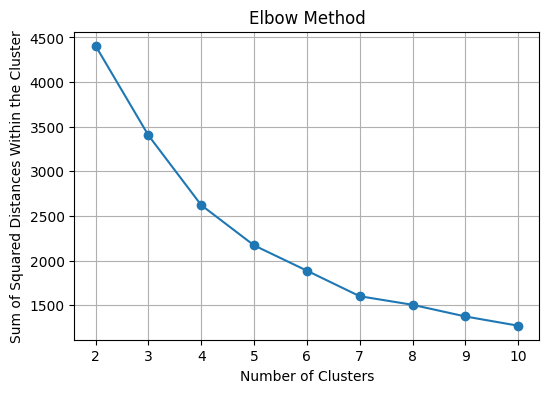

In [ ]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(6, 4))

# Plotting the WCSS values for different cluster counts
plt.plot(range(2, 11), wcss, marker="o")

# Labeling the axes and title
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances Within the Cluster")
plt.title("Elbow Method")
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
n_clusters = []
silhouette_score = []
for n_cluster in range(2, 31):

  kmeans = KMeans(featuresCol="featuresStand", k=n_cluster, maxIter=100, predictionCol='prediction')
  model = kmeans.fit(data)
  predictions = model.transform(data)
  evaluator = ClusteringEvaluator(featuresCol="featuresStand")
  silhouette = evaluator.evaluate(predictions)
  n_clusters.append(n_cluster)
  silhouette_score.append(silhouette)
  print(f"Silhouette Score: {silhouette}", "NCluster:",n_cluster)

Silhouette Score: 0.40729774252870504 NCluster: 2
Silhouette Score: 0.4174356278048225 NCluster: 3
Silhouette Score: 0.41801112425442233 NCluster: 4
Silhouette Score: 0.4535991198275614 NCluster: 5
Silhouette Score: 0.46962260424959146 NCluster: 6
Silhouette Score: 0.4674499610680464 NCluster: 7
Silhouette Score: 0.4711035157023028 NCluster: 8
Silhouette Score: 0.4470920774808307 NCluster: 9
Silhouette Score: 0.4412334419415958 NCluster: 10
Silhouette Score: 0.44357001071775604 NCluster: 11
Silhouette Score: 0.42694920727175056 NCluster: 12
Silhouette Score: 0.4606657634776405 NCluster: 13
Silhouette Score: 0.44648077167561084 NCluster: 14
Silhouette Score: 0.4400946293767794 NCluster: 15
Silhouette Score: 0.4480784280608501 NCluster: 16
Silhouette Score: 0.4439433992716086 NCluster: 17
Silhouette Score: 0.4378838149357086 NCluster: 18
Silhouette Score: 0.42692435340940316 NCluster: 19
Silhouette Score: 0.4263120582237524 NCluster: 20
Silhouette Score: 0.4380338602642709 NCluster: 21
S

Minumun error:  0.40729774252870504 at n_neighbors 1


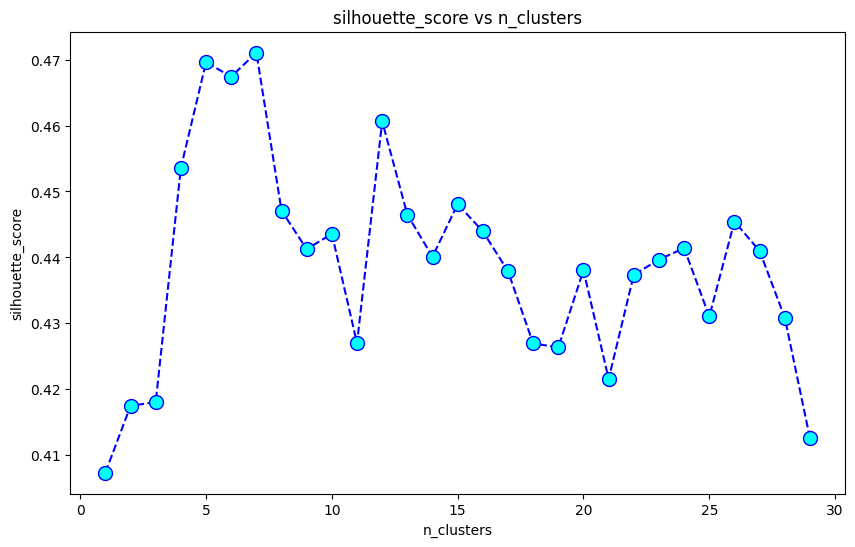

In [ ]:
#ahora vamos a graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(range(1,30), silhouette_score, color='blue', linestyle='dashed', # x esta en un rango de 1 a 10
         marker='o',markerfacecolor='cyan',markersize=10)
plt.title('silhouette_score vs n_clusters') #agrega el titulo a la grafica
plt.xlabel('n_clusters')
plt.ylabel('silhouette_score')
print('Minumun error: ', min(silhouette_score), 'at n_neighbors', silhouette_score.index(min(silhouette_score))+1) #imprime el menor error y el numero de vecinos para tener este menor error

In [ ]:
n_clusters = 8
kmeans = KMeans(featuresCol="featuresStand", k=n_clusters, maxIter=100, predictionCol='prediction',  )
model = kmeans.fit(data)
predictions = model.transform(data)
evaluator = ClusteringEvaluator(featuresCol="featuresStand")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}", "NCluster:",n_clusters)

Silhouette Score: 0.4711035157023028 NCluster: 8


ValueError: 'Spending Score (1-100)' is not in list

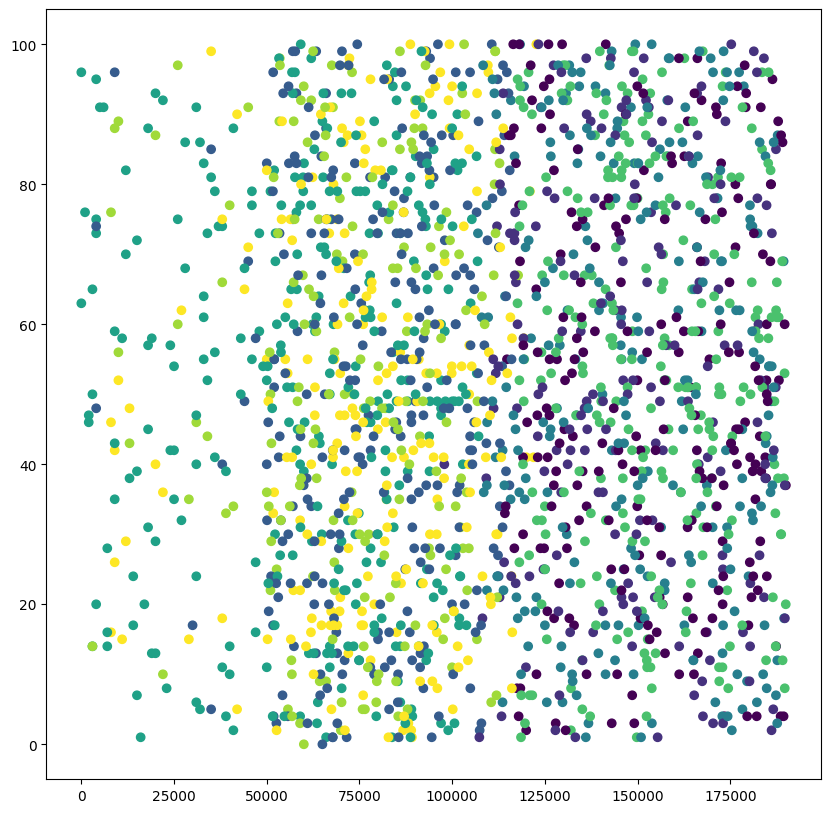

In [ ]:
cluster_centers = model.clusterCenters()

feature1 = "Annual Income ($)"
feature2 = "Spending Score (1-100)"

plt.figure(figsize=(10,10))
plt.scatter(data.select(feature1).collect(), data.select(feature2).collect(), c=predictions.select("prediction").collect())
plt.scatter([center[input_features.index(feature1)] for center in cluster_centers], [center[input_features.index(feature2)] for center in cluster_centers], marker='x', color='red')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Customer Segments")
plt.show()

Visualize the results

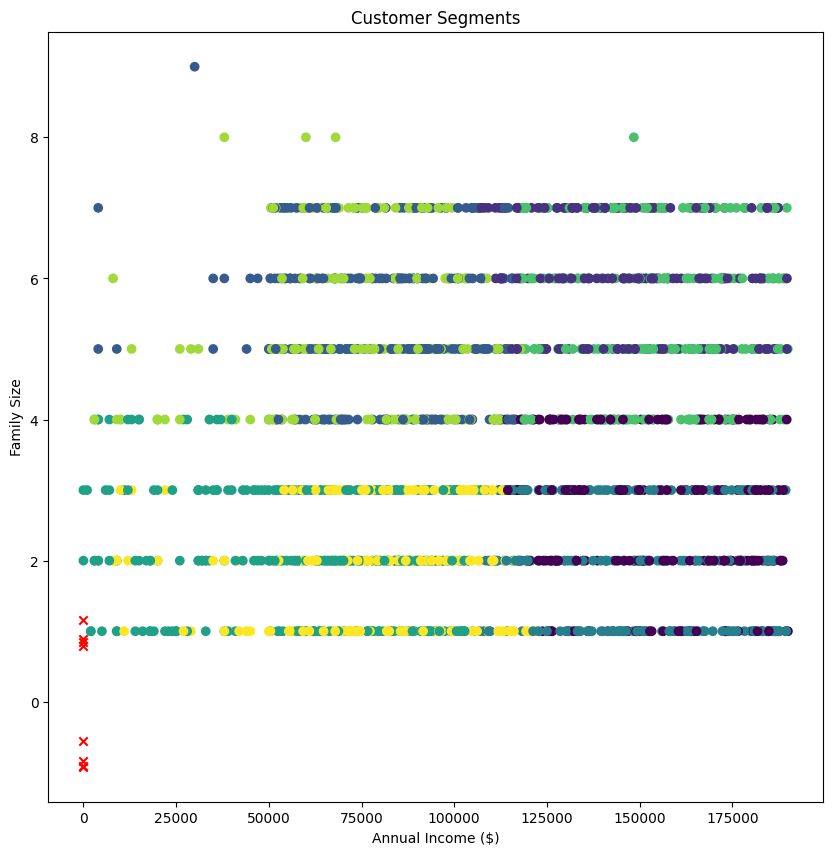

In [ ]:
cluster_centers = model.clusterCenters()

feature1 = "Annual Income ($)"
feature2 = "Family Size"

plt.figure(figsize=(10,10))
plt.scatter(data.select(feature1).collect(), data.select(feature2).collect(), c=predictions.select("prediction").collect())
plt.scatter([center[input_features.index(feature1)] for center in cluster_centers], [center[input_features.index(feature2)] for center in cluster_centers], marker='x', color='red')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Customer Segments")
plt.show()

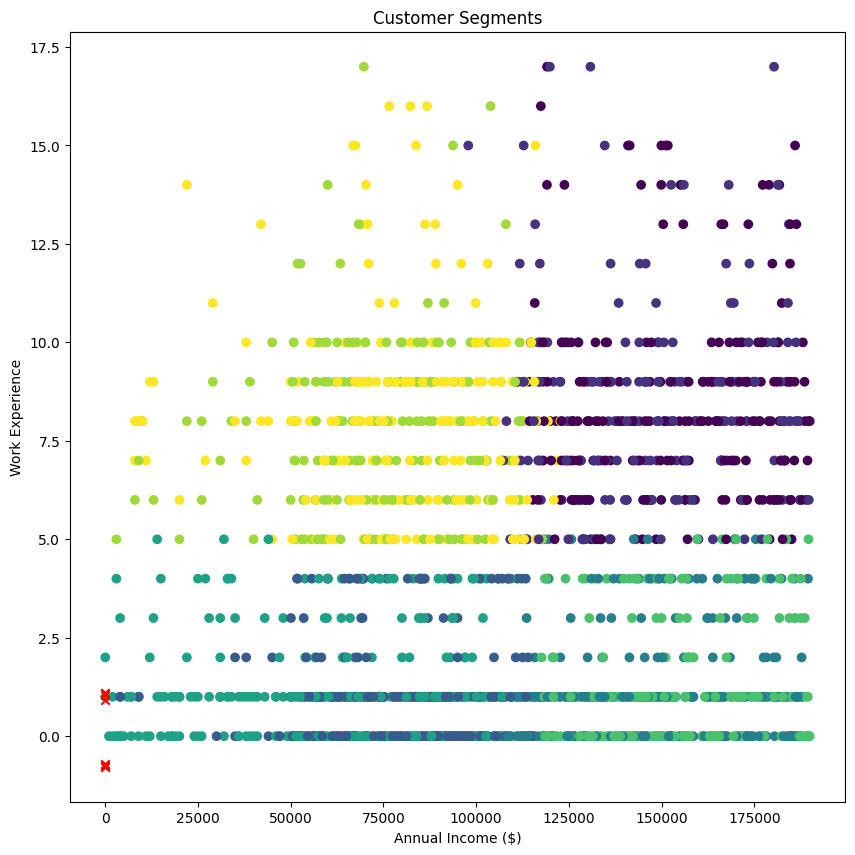

In [ ]:
cluster_centers = model.clusterCenters()

feature1 = "Annual Income ($)"
feature2 = "Work Experience"

plt.figure(figsize=(10,10))
plt.scatter(data.select(feature1).collect(), data.select(feature2).collect(), c=predictions.select("prediction").collect())
plt.scatter([center[input_features.index(feature1)] for center in cluster_centers], [center[input_features.index(feature2)] for center in cluster_centers], marker='x', color='red')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Customer Segments")
plt.show()

In [ ]:
dataset= data.toPandas()
dataset.to_numpy()
dataset

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,GenderIndex,ProfessionIndex,features,featuresNorm,featuresStand
0,1,Male,19,15000,39,Healthcare,1,4,1.0,1.0,"[15000.0, 1.0, 4.0]","[0.0789581732237043, 0.058823529411764705, 0.375]","[-2.0861435031378455, -0.7876361376055426, 0.1..."
1,2,Male,21,35000,81,Engineer,3,3,1.0,3.0,"[35000.0, 3.0, 3.0]","[0.1842357375219767, 0.1764705882352941, 0.25]","[-1.649784882786511, -0.27827131601762456, -0...."
2,3,Female,20,86000,6,Engineer,1,1,0.0,3.0,"[86000.0, 1.0, 1.0]","[0.4526935264825713, 0.058823529411764705, 0.0]","[-0.5370704008906073, -0.7876361376055426, -1...."
3,4,Female,23,59000,77,Lawyer,0,2,0.0,6.0,"[59000.0, 0.0, 2.0]","[0.31056881467990355, 0.0, 0.125]","[-1.1261545383649092, -1.0423185483995017, -0...."
4,5,Female,31,38000,40,Entertainment,2,6,0.0,2.0,"[38000.0, 2.0, 6.0]","[0.20002737216671754, 0.11764705882352941, 0.625]","[-1.5843310897338105, -0.5329537268115836, 1.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,1996,Female,71,184387,40,Artist,8,7,0.0,0.0,"[184387.0, 8.0, 7.0]","[0.9705907124132775, 0.47058823529411764, 0.75]","[1.6095303781347312, 0.9951407379521706, 1.647..."
1961,1997,Female,91,73158,32,Doctor,7,7,0.0,4.0,"[73158.0, 7.0, 7.0]","[0.38509480244665056, 0.4117647058823529, 0.75]","[-0.8172562710181993, 0.7404583271582116, 1.64..."
1962,1998,Male,87,90961,14,Healthcare,9,2,1.0,1.0,"[90961.0, 9.0, 2.0]","[0.47880762630675777, 0.5294117647058824, 0.125]","[-0.4288316451124587, 1.2498231487461295, -0.8..."
1963,1999,Male,77,182109,4,Executive,7,2,1.0,5.0,"[182109.0, 7.0, 2.0]","[0.9585995978397044, 0.4117647058823529, 0.125]","[1.559829131276714, 0.7404583271582116, -0.892..."


<Figure size 2000x800 with 0 Axes>

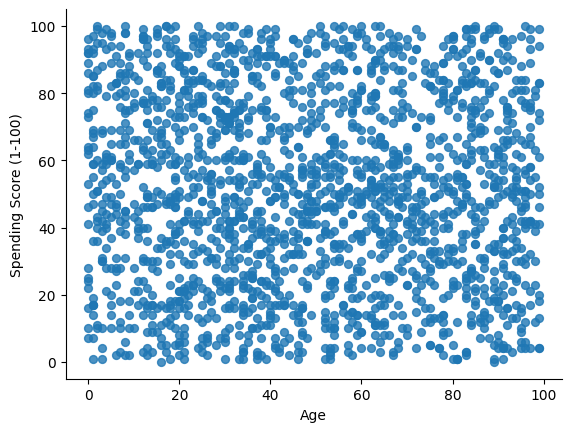

In [ ]:
####
plt.figure(figsize=(20,8))
from matplotlib import pyplot as plt
dataset.plot(kind='scatter', x='Age', y='Spending Score (1-100)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Some useful fuctions for the task

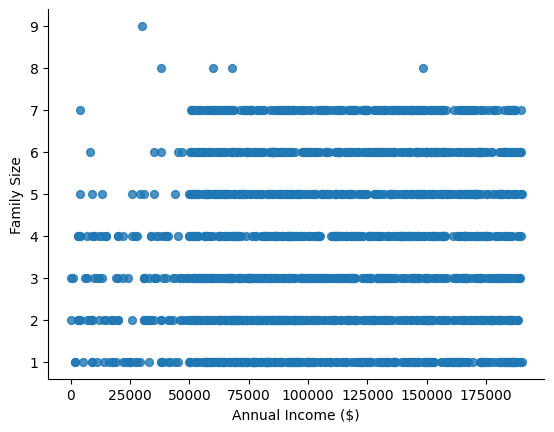

In [ ]:
from matplotlib import pyplot as plt
dataset.plot(kind='scatter', x='Annual Income ($)', y='Family Size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

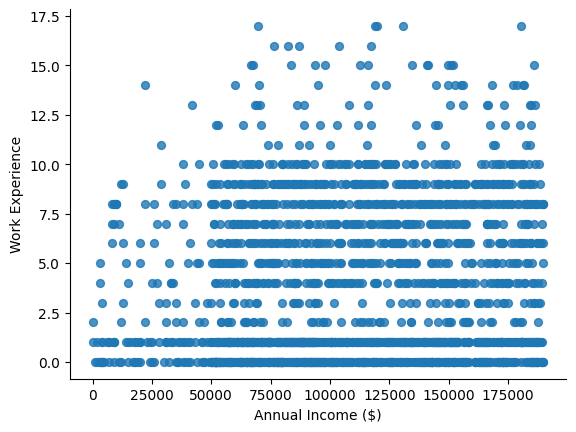

In [ ]:
from matplotlib import pyplot as plt
dataset.plot(kind='scatter', x='Annual Income ($)', y='Work Experience', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Normalization
# from pyspark.ml.feature import MinMaxScaler, StandardScaler
# Removing rows with null values
# data = data.na.drop()